INFO:drake:Meshcat listening for connections at http://localhost:7006


geomtery:  InputPort[0] (geometry_query) of System ::plant (MultibodyPlant<double>)
diagram systems:


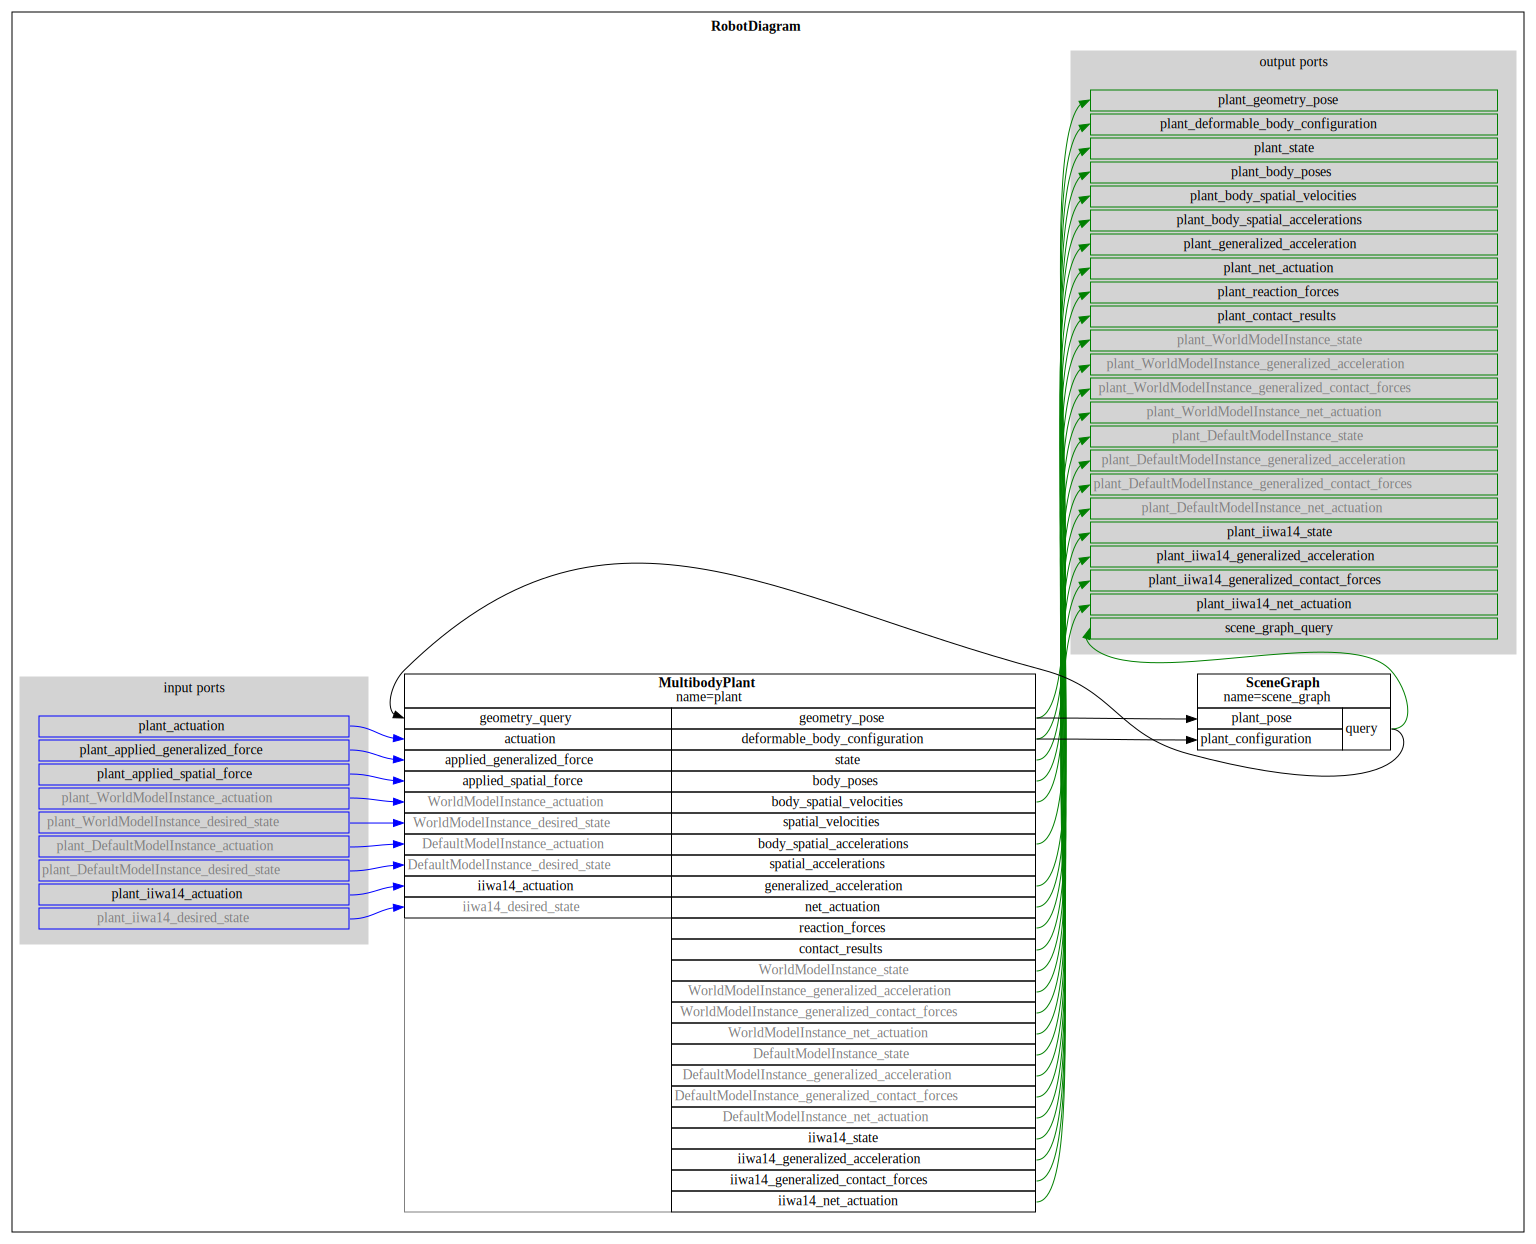

plant topology:


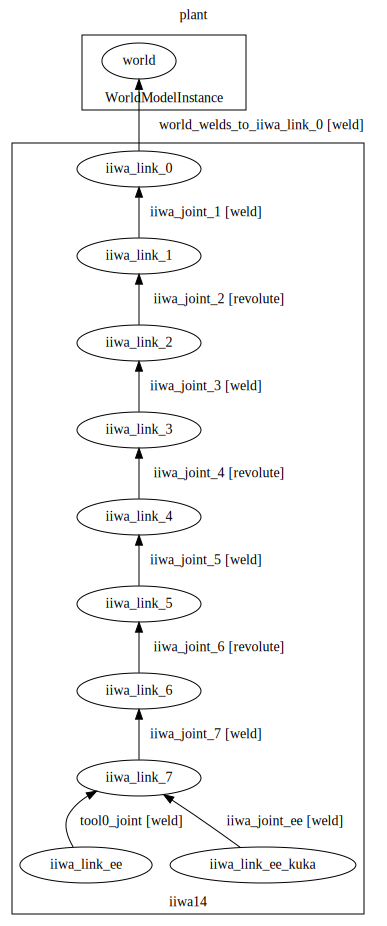

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG, display
import pydot

from pydrake.all import (
    Parser,
    Rgba,
    RigidTransform,
    Solve,
    Sphere,
    StartMeshcat,
    DirectCollocation,
    MultibodyPlant,
    PiecewisePolynomial,
    SceneGraph,
    RobotDiagramBuilder
)

from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddWsg
from underactuated import ConfigureParser, running_as_notebook

def dircol_kuka(N, min_dt, max_dt):
    meshcat = StartMeshcat()
    meshcat.Delete()
    
    initial_state = [0.40236988, -1.36484125, -0.1, 0.0, 0.0, 0.0]
    final_state = [0.60544649, -1.75551969, -0.69582573, 0.0, 0.0, 0.0]

    builder = RobotDiagramBuilder(time_step=0.0)
    ConfigureParser(builder.parser())
    iiwa = builder.parser().AddModelsFromUrl("package://drake_models/iiwa_description/urdf/planar_iiwa14_spheres_dense_elbow_collision.urdf")[0]
    
    plant = builder.plant()

    # plant = MultibodyPlant(0.0)
    # scene_graph = SceneGraph()
    # plant.RegisterAsSourceForSceneGraph(scene_graph)
    # parser = Parser(plant)
    # ConfigureParser(parser)
    # iiwa = parser.AddModelsFromUrl(
    #     "package://drake_models/iiwa_description/urdf/planar_iiwa14_spheres_dense_elbow_collision.urdf"
    # )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    
    assert plant.geometry_source_is_registered()


    # wsg = AddWsg(plant, iiwa, roll=0.0, welded=True, sphere=True)
    # X_WStart = RigidTransform([0.8, 0, 0.65])
    # meshcat.SetObject("start", Sphere(0.02), rgba=Rgba(0.9, 0.1, 0.1, 1))
    # meshcat.SetTransform("start", X_WStart)
    # X_WGoal = RigidTransform([0.8, 0, 0.4])
    # meshcat.SetObject("goal", Sphere(0.02), rgba=Rgba(0.1, 0.9, 0.1, 1))
    # meshcat.SetTransform("goal", X_WGoal)

    # Set default positions:
    # joint 1, 3, 5 and 7 are fixed to make kuka planar
    joint_2 = plant.GetMutableJointByName("iiwa_joint_2")
    joint_4 = plant.GetMutableJointByName("iiwa_joint_4")
    joint_6 = plant.GetMutableJointByName("iiwa_joint_6")
    joint_2.set_default_angle(initial_state[0])
    joint_4.set_default_angle(initial_state[1])
    joint_6.set_default_angle(initial_state[2])

    # plant.Finalize()
    # context = plant.CreateDefaultContext()

    print('geomtery: ', plant.get_geometry_query_input_port().GetFullDescription() )

    diagram = builder.Build()
    diag_context = diagram.CreateDefaultContext()

    plant_context = plant.GetMyContextFromRoot(diag_context)

    print('diagram systems:')
    display(
        SVG(
                pydot.graph_from_dot_data(diagram.GetGraphvizString ())[0].create_svg()
            )
    )
    print('plant topology:')
    display(
        SVG(
            pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()
        )
    )

    dircol = DirectCollocation(
        diagram, 
        diag_context,
        num_time_samples=N,
        minimum_time_step=min_dt,
        maximum_time_step=max_dt,
        input_port_index = plant.get_actuation_input_port().get_index()
    )
    prog = dircol.prog()
    # dircol.AddEqualTimeIntervalsConstraints()

    # prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())
    # prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())

    # dircol.AddRunningCost(dircol.input()[0] ** 2 + dircol.input()[1] ** 2 + dircol.input()[2] ** 2)
    # dircol.AddFinalCost(dircol.time())

    initial_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((initial_state, final_state))
    )  # yapf: disable

    # initial_u = PiecewisePolynomial()
    # dircol.SetInitialTrajectory(initial_u, initial_trajectory)

    result = Solve(prog)
    
N = 10
dircol_kuka(N, min_dt=0.5/N, max_dt=2.0/N)